# **Conv2D-Mel spectogram**

In [ ]:
import numpy as np
import librosa
import pandas as pd
import tensorflow as tf

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
data_path=pd.read_csv("/content/gdrive/MyDrive/Colab Notebooks/FYP-SER/data_path.csv")

In [ ]:
def extract_features(data):
    data=data[:44100]
    zero_padding=tf.zeros([44100] - tf.shape(data), dtype=tf.float32)
    data=tf.concat([zero_padding, data], 0)
    data=np.array(data)
    mel=librosa.feature.melspectrogram(y=data, sr=22050)
    return mel


In [ ]:
#Data Augmentation

def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate)

def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sampling_rate, pitch_factor)

In [ ]:
def remove_silent(data):
    data=librosa.effects.trim(data, top_db = 30)[0]
    return data

In [ ]:
def get_features(path,i):
    # duration and offset are used to take care of the no audio in start and the ending of each audio files as seen above.
    data, sample_rate = librosa.load(path, sr=22050)
    data=remove_silent(data)
    
    # without augmentation
    if i==0:
      res1 = extract_features(data)
      result = np.array(res1)
      
    # data with noise
    if i==1:
      noise_data = noise(data)
      result = extract_features(noise_data)
      # result = np.vstack((result, res2)) # stacking vertically
    
    # data with stretching and pitching
    if i==2:
      new_data = stretch(data)
      data_stretch_pitch = pitch(new_data, sample_rate)
      result = extract_features(data_stretch_pitch)
      # result = np.vstack((result, res3)) # stacking vertically
    
    return result

In [ ]:
X, Y = [], []
for path, emotion in zip(data_path.Path, data_path.Emotions):
    for i in range(3):
        feature = get_features(path,i)
        X.append(feature)
        # appending emotion 3 times as we have made 3 augmentation techniques on each audio file.
        Y.append(emotion)

In [ ]:
len(X),len(Y)

(4320, 4320)

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Conv1D, MaxPooling1D,MaxPooling2D, Flatten, Dropout, BatchNormalization

In [ ]:
# As this is a multiclass classification problem onehotencoding our Y.
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

In [ ]:
X=np.array(X)

In [ ]:
# splitting data
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=0, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((3240, 128, 87), (3240, 8), (1080, 128, 87), (1080, 8))

In [ ]:
# making our data compatible to model.
x_train = np.expand_dims(x_train, axis=3)
x_test = np.expand_dims(x_test, axis=3)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((3240, 128, 87, 1), (3240, 8), (1080, 128, 87, 1), (1080, 8))

In [ ]:
#@title Default title text
#Modelling

model=Sequential()
model.add(Conv2D(256, (5,5), activation='tanh',padding='same', input_shape=(x_train.shape[1],x_train.shape[2],1)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(3,3), padding='same'))


model.add(Conv2D(512, (5,5), activation='tanh',padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(3,3), padding='same'))


model.add(Conv2D(256, (5,5), activation='tanh',padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(3,3), padding='same'))


model.add(Conv2D(128, (5,5), activation='tanh',padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(3,3), padding='same'))


model.add(Flatten())

model.add(Dense(64, activation='tanh'))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(Dense(8, activation='softmax'))
model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 87, 256)      6656      
                                                                 
 batch_normalization (BatchN  (None, 128, 87, 256)     1024      
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 43, 29, 256)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 43, 29, 512)       3277312   
                                                                 
 batch_normalization_1 (Batc  (None, 43, 29, 512)      2048      
 hNormalization)                                                 
                                                        

In [ ]:
rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4, verbose=0, patience=2, min_lr=0.0000001)
n_epochs=100
history=model.fit(x_train, y_train, batch_size=64, epochs=n_epochs, validation_data=(x_test, y_test), callbacks=[rlrp])

Epoch 1/100
51/51 [==============================] - 27s 293ms/step - loss: 2.0672 - accuracy: 0.2605 - val_loss: 1.9517 - val_accuracy: 0.2565 - lr: 0.0010
Epoch 2/100
51/51 [==============================] - 11s 220ms/step - loss: 1.9171 - accuracy: 0.2836 - val_loss: 3.4586 - val_accuracy: 0.1463 - lr: 0.0010
Epoch 3/100
51/51 [==============================] - 12s 226ms/step - loss: 1.8196 - accuracy: 0.3154 - val_loss: 3.3975 - val_accuracy: 0.1463 - lr: 0.0010
Epoch 4/100
51/51 [==============================] - 11s 225ms/step - loss: 1.7803 - accuracy: 0.3302 - val_loss: 3.1945 - val_accuracy: 0.1463 - lr: 0.0010
Epoch 5/100
51/51 [==============================] - 11s 224ms/step - loss: 1.7457 - accuracy: 0.3373 - val_loss: 2.4033 - val_accuracy: 0.2102 - lr: 0.0010
Epoch 6/100
51/51 [==============================] - 11s 221ms/step - loss: 1.6991 - accuracy: 0.3556 - val_loss: 2.6858 - val_accuracy: 0.1954 - lr: 0.0010
Epoch 7/100
51/51 [==============================] - 11s 2

34/34 [==============================] - 3s 59ms/step - loss: 0.9485 - accuracy: 0.7620
Accuracy of our model on test data :  76.20370388031006 %


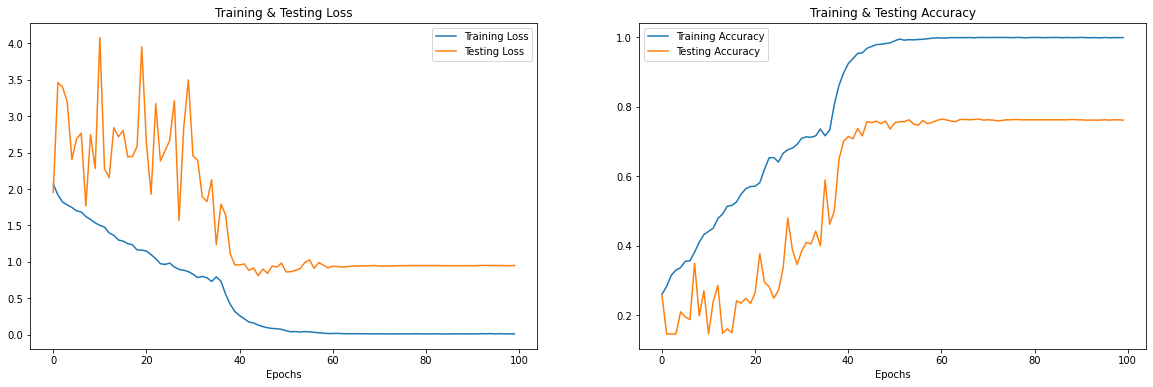

In [ ]:
print("Accuracy of our model on test data : " , model.evaluate(x_test,y_test)[1]*100 , "%")

epochs = [i for i in range(n_epochs)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [ ]:
# predicting on test data.
pred_test = model.predict(x_test)
y_pred = encoder.inverse_transform(pred_test)

y_test = encoder.inverse_transform(y_test)

34/34 [==============================] - 1s 34ms/step


In [ ]:
df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred.flatten()
df['Actual Labels'] = y_test.flatten()

df

,Predicted Labels,Actual Labels
0,calm,calm
1,disgust,disgust
2,surprise,surprise
3,calm,calm
4,disgust,disgust
...,...,...
1075,surprise,surprise
1076,calm,calm
1077,disgust,disgust
1078,neutral,neutral


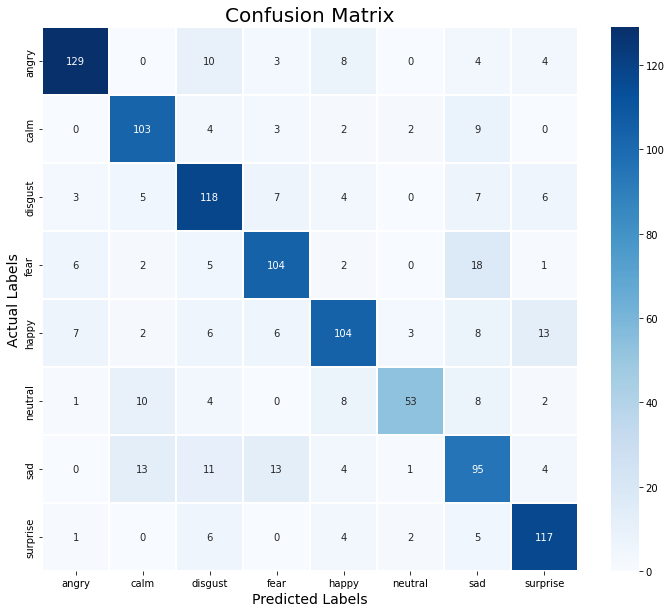

In [ ]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       angry       0.88      0.82      0.85       158
        calm       0.76      0.84      0.80       123
     disgust       0.72      0.79      0.75       150
        fear       0.76      0.75      0.76       138
       happy       0.76      0.70      0.73       149
     neutral       0.87      0.62      0.72        86
         sad       0.62      0.67      0.64       141
    surprise       0.80      0.87      0.83       135

    accuracy                           0.76      1080
   macro avg       0.77      0.76      0.76      1080
weighted avg       0.77      0.76      0.76      1080

